In [1]:
!pip install keras

    100% |████████████████████████████████| 307kB 7.4MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 8.9MB/s ta 0:00:01


In [4]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from PIL import Image
import tcu_images

Saving 500 images to /home/catherio/datasets/tcu_images/test/bird     (using 64 parallel processes)


100%|██████████| 500/500 [00:15<00:00, 31.71it/s]

Saving 500 images to /home/catherio/datasets/tcu_images/test/bicycle     (using 64 parallel processes)



100%|██████████| 500/500 [00:16<00:00, 30.90it/s]


Cropping images to correct shape and size...


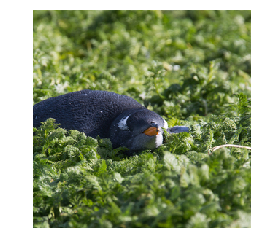

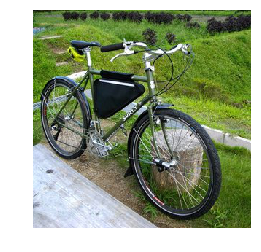

In [6]:
from keras.preprocessing import image
import os.path as osp
import os
import seaborn as sns

DATASET_ROOT = tcu_images.get_dataset('test')

image_paths_bicycle = os.listdir(osp.join(DATASET_ROOT, 'bicycle'))
image_paths_bicycle = [os.path.join(DATASET_ROOT,'bicycle', path) for path in image_paths_bicycle]

image_paths_bird = os.listdir(osp.join(DATASET_ROOT, 'bird'))
image_paths_bird = [os.path.join(DATASET_ROOT,'bird', path) for path in image_paths_bird]

# Truncate eval dataset
image_paths_bird = image_paths_bird[:500]
image_paths_bicycle = image_paths_bicycle[:500]

def show_image(im):
    plt.axis('off')
    im = image.load_img(im, target_size=(299, 299))
    plt.imshow(im)
    plt.show()
    
show_image(image_paths_bird[0])
show_image(image_paths_bicycle[0])

In [7]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import numpy as np

model = InceptionResNetV2(weights='imagenet')


225214464/225209952 [==============================] - 9s 0us/step


In [10]:
np.max(x)

1.0

Predicted: [('n02056570', 'king_penguin', 0.91505873), ('n02484975', 'guenon', 0.011434144), ('n01945685', 'slug', 0.003505979)]


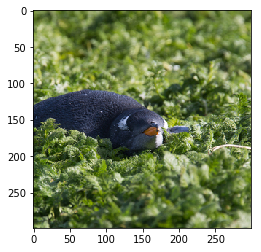

In [11]:
# Show one item

img = image.load_img(image_paths_bird[0], target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

probs = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(probs, top=3)[0])

plt.imshow((x[0] / 2.0) + 0.5)
plt.show()

In [12]:
# Collect all the logits and images in arrays
import os
image_paths = image_paths_bicycle + image_paths_bird

# bird is one
y_true = np.concatenate([np.zeros((len(image_paths_bicycle),)), np.ones((len(image_paths_bird),))])

In [35]:
# Run the whole dataset through & get probabilities

batch_size = 32
from tqdm import tqdm as tqdm

def to_batches(iterable, batch_size):
    return [iterable[i * batch_size:(i + 1) * batch_size]
          for i in range((len(iterable) + batch_size - 1) // batch_size)]

image_patch_batches = to_batches(image_paths, batch_size)

probs = []
for batch in tqdm(image_patch_batches):
    x_batch = []
    for img_path in batch:
        img = image.load_img(img_path, target_size=(299, 299))
        x_batch.append(image.img_to_array(img))

    x_batch = np.stack(x_batch)
    x_batch = preprocess_input(x_batch)
    probs.append(model.predict(x_batch))
    
probs = np.concatenate(probs)
        

100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


In [41]:
# TODO: See if more classes helps here
BIRD_CLASSES = list(range(80,100+1))
BICYCLE_CLASSES = [671, 444]

print(BIRD_CLASSES)

bird_probs = np.max(probs[:, BIRD_CLASSES], axis=1)
bicycle_probs = np.max(probs[:, BICYCLE_CLASSES], axis=1)


[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [42]:
is_correct = (bird_probs > bicycle_probs) == y_true.astype(np.bool)
print("accuracy: ")
np.mean(is_correct)

# Previous: 0.964517625231911
# use my graphing code

accuracy: 


0.999

In [43]:
bicycle_probs[0]

0.5207845

(1000,)


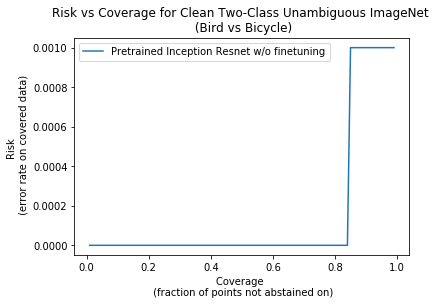

In [31]:

labels = bird_probs > bicycle_probs
confidences = np.max(np.vstack([bird_probs, bicycle_probs]).T, axis=1)
# confidences = np.abs(bird_probs - bicycle_probs)

def plot_confident_error_rate(labels, confidences, y_true, title="Risk vs Coverage"):
    sorted_confidences = list(sorted(confidences, reverse=True))

    coverages = np.linspace(0.01, .99, 99)
    cov_to_confident_error_idxs = []

    for coverage in coverages:    
        threshold = sorted_confidences[int(coverage * len(labels))]
        confident_mask = confidences >= threshold
        confident_error_mask = (y_true != labels) * confident_mask
        confident_error_idx = confident_error_mask.nonzero()[0]
        
        cov_to_confident_error_idxs.append(confident_error_idx)
        
    plt.plot(coverages, [float(len(idxs)) / len(labels) for idxs in cov_to_confident_error_idxs])
    plt.title(title)
    plt.ylabel("Risk \n (error rate on covered data)")
    plt.xlabel("Coverage \n (fraction of points not abstained on)")
    
    plt.legend(["Pretrained Inception Resnet w/o finetuning"])
    plt.show()
    return cov_to_confident_error_idxs
    
cov_to_confident_error_idxs = plot_confident_error_rate(
    labels, confidences_2, y_true, title="Risk vs Coverage for Clean Two-Class Unambiguous ImageNet \n (Bird vs Bicycle)")

In [18]:
print(len(cov_to_confident_error_idxs))

99


True: bicycle
Pred: bird


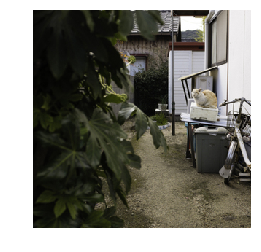

In [19]:
incorrect_idxs = cov_to_confident_error_idxs[90]

for idx in incorrect_idxs:
    print("True: %s" %('bird' if y_true[idx] else 'bicycle'))
    print("Pred: %s" %('bird' if labels[idx] else 'bicycle'))
#     print(np.argmax(preds[idx, BOAT_CLASSES]))
    show_image(image_paths[idx])